In [6]:
%matplotlib inline
import numpy as np
MEPS = np.finfo(float).eps
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib

from scipy.optimize import minimize_scalar
from scipy.stats import linregress as linreg

from scipy.interpolate import lagrange, CubicSpline
import numpy.polynomial.polynomial as poly

from halton import halton_sequence

In [7]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
n = 10
eps = 800
#pnts = 'halton'
pnts = 'equal'

def foo(x):
    return np.exp(-np.cos(10*np.pi*x) * x)

def rbf(r, eps):
    return np.exp(-(eps*r)**2)
    #return r**5

if pnts == 'halton':
    xs = np.zeros(n)
    xs[1:-1] = halton_sequence(1, (n-2), 1).flatten() #generates n halton points between 0 and 1
    xs[0] = 0 # add the interior points
    xs[-1] = 1
elif pnts == 'equal':
    xs = np.linspace(0,1,n)

zs = np.linspace(0,1, 1000)

Vandermonde condition number = 		1.51932e+07
Radial Basis condition number = 	1


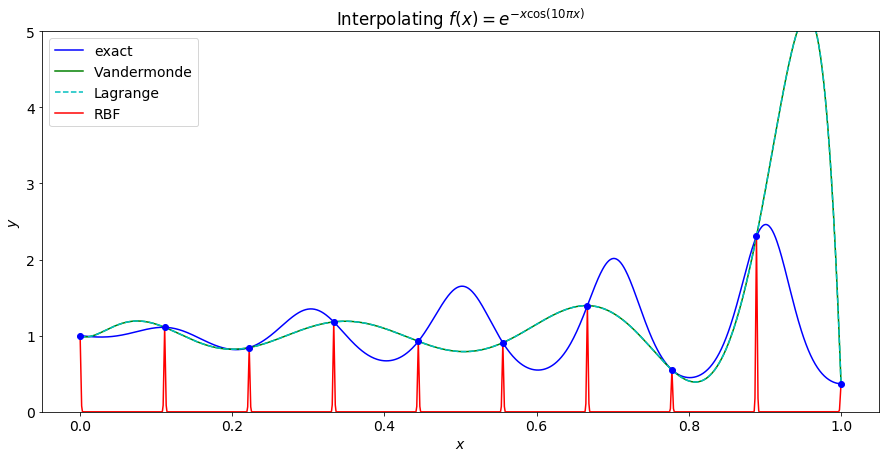

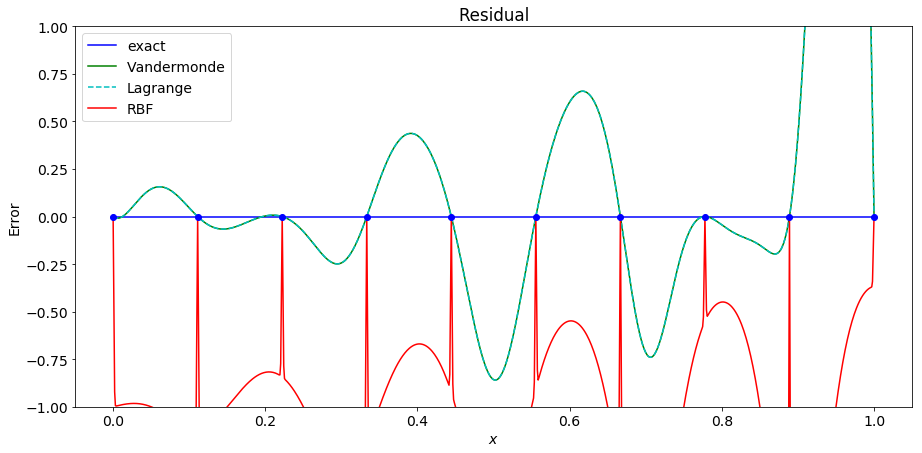

In [4]:
A = xs.reshape((n,1)) ** np.arange(n)
print('Vandermonde condition number = \t\t%g' % la.cond(A))
cs = la.solve(A, foo(xs))
A_new = zs.reshape((len(zs),1)) ** np.arange(n)
van = A_new @ cs

l_poly = lagrange(xs, foo(xs))
l_poly_pnts = l_poly(zs)

A = rbf(np.abs(np.subtract.outer(xs,xs)), eps)
print('Radial Basis condition number = \t%g' % la.cond(A))

cs = la.solve(A, foo(xs))

A_new = rbf(np.abs(np.subtract.outer(zs,xs)), eps)

rbf_interp = A_new @ cs


fig = plt.figure(figsize=(15,7))
plt.plot(zs, foo(zs), 'b-')
plt.plot(zs, van, 'g-')
plt.plot(zs, l_poly_pnts, 'c--')
plt.plot(zs, rbf_interp, 'r-')
plt.plot(xs, foo(xs), 'bo')
plt.ylim((0, 5))
plt.legend(['exact', 'Vandermonde', 'Lagrange', 'RBF'])
plt.title('Interpolating $f(x) = e^{-x\cos(10\pi x)}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

fig = plt.figure(figsize=(15,7))
plt.plot(zs, [0]*len(zs), 'b-')
plt.plot(zs, van-foo(zs), 'g-')
plt.plot(zs, l_poly_pnts-foo(zs), 'c--')
plt.plot(zs, rbf_interp-foo(zs), 'r-')
plt.plot(xs, [0]*n, 'bo')
plt.legend(['exact', 'Vandermonde', 'Lagrange', 'RBF'])
plt.title('Residual')
plt.xlabel('$x$')
plt.ylabel('Error')
y_max = np.max(np.abs(rbf_interp-foo(zs)))*1.1
y_max = np.min([y_max, 1])
plt.ylim((-y_max,y_max))
plt.show()

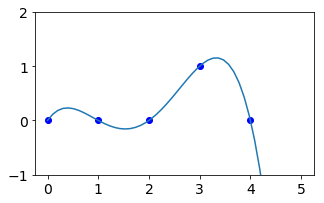

In [5]:
xs = range(5)
ys = [0,0,0,1,0]
l_poly = lagrange(xs,ys)
zs = np.linspace(0,5)
fig = plt.figure(figsize=(5,3))
plt.plot(xs, ys, 'bo')
plt.plot(zs, l_poly(zs))
plt.ylim((-1,2))
plt.show()

# Shape Parameter Selection

Radial Basis condition number = 	1


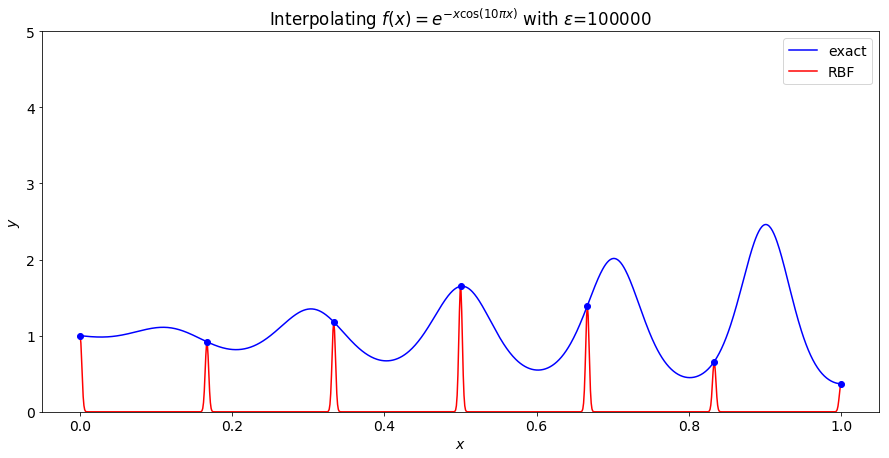

In [6]:
n = 7
eps = 10**5

def foo(x):
    return np.exp(-np.cos(10*np.pi*x) * x)

def rbf(r, eps):
    return np.exp(-eps * r**2)
    
xs = np.linspace(0,1,n)
zs = np.linspace(0,1, 1000)

A = rbf(np.abs(np.subtract.outer(xs,xs)), eps)
print('Radial Basis condition number = \t%g' % la.cond(A))

cs = la.solve(A, foo(xs))
A_new = rbf(np.abs(np.subtract.outer(zs,xs)), eps)

rbf_interp = A_new @ cs

fig = plt.figure(figsize=(15,7))
plt.plot(zs, foo(zs), 'b-')
plt.plot(zs, rbf_interp, 'r-')
plt.plot(xs, foo(xs), 'bo')
plt.ylim((0, 5))
plt.legend(['exact', 'RBF'])
plt.title('Interpolating $f(x) = e^{-x\cos(10\pi x)}$ with $\\varepsilon$=%d' % eps)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

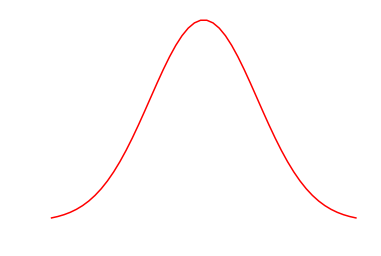

In [7]:
plt.axis('off')
plt.plot(np.linspace(-2,2), rbf(np.linspace(-2,2), 1), 'r-')

# Convergence Rates

In [13]:
rbf_dict = {}
shape_labels = []
phs_labels = []

# Shape paramater RBFs

def rbf(r, eps):
    return np.exp(-(eps*r)**2)
rbf_label = 'gaussian'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

def rbf(r, eps):
    return np.sqrt(1+(eps*r)**2)
rbf_label = 'multiquadric'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

def rbf(r, eps):
    return 1/(1+(eps*r)**2)
rbf_label = 'inverse quadratic'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

def rbf(r, eps):
    return 1/np.sqrt(1+(eps*r)**2)
rbf_label = 'inverse multiquadric'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

# PHS RBFs

def rbf(r,eps):
    return r**2 * np.log(r+MEPS)
rbf_label = '$\\log(r)r^2$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

def rbf(r,eps):
    return r**3
rbf_label = '$r^3$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

def rbf(r,eps):
    return r**4 * np.log(r+MEPS)
rbf_label = '$\\log(r)r^4$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

def rbf(r,eps):
    return r**5
rbf_label = '$r^5$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

rbf_labels = shape_labels + phs_labels

In [14]:
def functional(eps, dist_mat, rbf , target_cond):
    return np.log( la.cond(rbf(dist_mat, eps)) / target_cond)**2

def optimize_eps(rbf, dist_mat, target_cond=10**12):
    n = dist_mat.shape[0]
    eps_guess = 1/np.min(dist_mat+np.diag([1]*n))
    optimization_result = minimize_scalar(functional, 
            bracket=[eps_guess/2, eps_guess*2],
            args=(dist_mat, rbf, target_cond))
    return optimization_result['x']

def rbf_interp(xs, fs, zs, rbf, shape=True, print_cond=False):
    dist_mat = np.abs(np.subtract.outer(xs,xs))
    if shape:
        eps = optimize_eps(rbf, dist_mat)
    else:
        eps = None
    A = rbf(dist_mat, eps)
    if print_cond:
        print('log Cond(A)= %g' % ( np.log(la.cond(A))/np.log(10) ) )
    cs = la.solve(A, fs)
    A = rbf(np.abs(np.subtract.outer(zs,xs)), eps)
    return A @ cs

log Cond(A)= 8.84565
RBF Error: 0.0346515
Cubic Error: 0.0435357


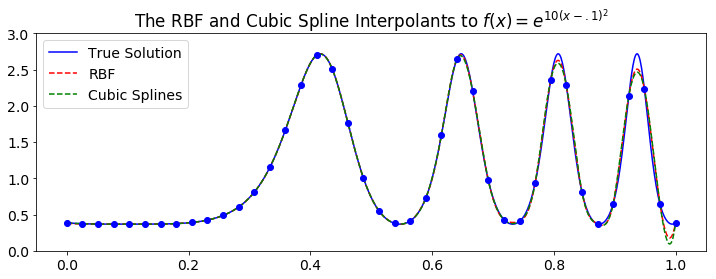

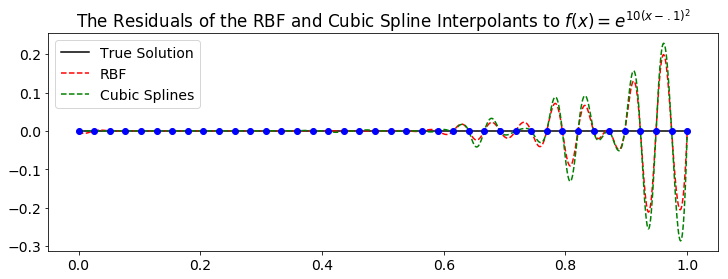

In [14]:
n = 40

def foo(x):
    #return np.exp(-np.cos(10*np.pi*x) * x)
    return np.exp(-np.cos(10*np.pi*(x-.1)**2) )

rbf = rbf_dict['$r^5$']

xs = np.linspace(0,1, n)
fs = foo(xs)

zs = np.linspace(0,1, 1000)

us = rbf_interp(xs, fs, zs, rbf, print_cond=True)
exact = foo(zs)
err = la.norm(us-exact)/la.norm(exact)
print('RBF Error: %g' % err)

cubic = CubicSpline(xs, fs)

us_cubic = cubic(zs)

cubic_err = la.norm(us_cubic-exact)/la.norm(exact)
print('Cubic Error: %g' % cubic_err)

legend = ['True Solution', 'RBF', 'Cubic Splines']

fig = plt.figure(figsize=(12,4))
plt.plot(zs, foo(zs),'b-')
plt.plot(zs, us, 'r--')
plt.plot(zs, us_cubic, 'g--')
plt.plot(xs, fs, 'bo')
plt.ylim((0,3))
plt.legend(legend)
plt.title('The RBF and Cubic Spline Interpolants to $f(x)=e^{10(x-.1)^2}$')
plt.show()

fig = plt.figure(figsize=(12,4))
plt.plot(zs, [0]*len(zs),'k-')
plt.plot(zs, us-exact, 'r--')
plt.plot(zs, us_cubic-exact, 'g--')
plt.plot(xs, [0]*len(xs), 'bo')
plt.legend(legend)
plt.title('The Residuals of the RBF and Cubic Spline Interpolants to $f(x)=e^{10(x-.1)^2}$')
plt.show()

In [11]:
ns = [8*2**i for i in range(7)]

foo_label = '$f(x) = e^{\cos(10 \pi (x-.1)^2)}$'
def foo(x):
    return np.exp(np.cos(10*np.pi*(x-.1)**2) )


errs = []
for rbf_label in shape_labels:
    my_errs = []
    for n in ns:
        rbf = rbf_dict[rbf_label]
        xs = np.linspace(0,1, n)
        fs = foo(xs)
        zs = np.linspace(0,1, 1000)
        us = rbf_interp(xs, fs, zs, rbf)
        exact = foo(zs)
        err = la.norm(us-exact)/la.norm(exact)
        my_errs.append(err)
    errs.append(my_errs)

for rbf_label in phs_labels:
    my_errs = []
    for n in ns:
        rbf = rbf_dict[rbf_label]
        xs = np.linspace(0,1, n)
        fs = foo(xs)
        zs = np.linspace(0,1, 1000)
        us = rbf_interp(xs, fs, zs, rbf, shape=False)
        exact = foo(zs)
        err = la.norm(us-exact)/la.norm(exact)
        my_errs.append(err)
    errs.append(my_errs)

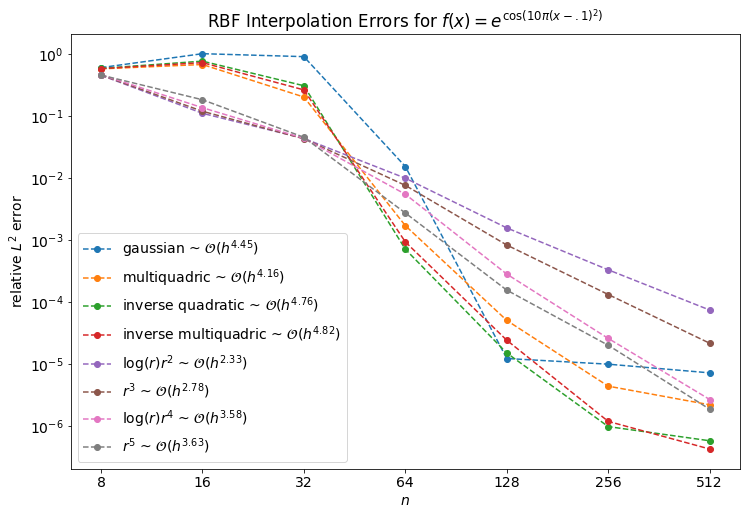

In [12]:
plt.figure(figsize=(12,8))

orders = []

for rbf_label, my_errs in zip(rbf_labels, errs):
    plt.loglog(ns, my_errs, '--o')
    orders.append(linreg(-np.log(ns[2:]), np.log(my_errs[2:]))[0] )
    
plt.legend([rbf + (' ~ $\mathcal{O}(h^{%.2f})$'%o) for rbf, o in zip(rbf_labels, orders)] )
plt.xticks(ns,ns)
plt.minorticks_off()
plt.xlabel('$n$')
plt.ylabel('relative $L^2$ error')
plt.title('RBF Interpolation Errors for ' + foo_label)
plt.show()

## Other shape parameter selection

In [15]:
def functional(eps, dist_mat, rbf , target_cond):
    return np.log( la.cond(rbf(dist_mat, eps)) / target_cond)**2

def optimize_eps(rbf, dist_mat, target_cond=10**12):
    n = dist_mat.shape[0]
    eps_guess = 1/np.min(dist_mat+np.diag([np.max(dist_mat)]*n))
    optimization_result = minimize_scalar(functional, 
            bracket=[eps_guess/2, eps_guess*2],
            args=(dist_mat, rbf, target_cond))
    return np.abs(optimization_result['x'])

def rbf_interp(xs, fs, zs, rbf, eps=1, optimize_shape=False, target_cond=10**12, print_cond=False):
    dist_mat = np.abs(np.subtract.outer(xs,xs))
    if optimize_shape:
        eps = optimize_eps(rbf, dist_mat)
    A = rbf(dist_mat, eps)
    A_cond = la.cond(A)
    if print_cond:
        print('log Cond(A)= %g' % ( np.log(A_cond)/np.log(10) ) )
    cs = la.solve(A, fs)
    A = rbf(np.abs(np.subtract.outer(zs,xs)), eps)
    return A @ cs, eps, A_cond

In [16]:
def gen_points(a,b, n, kind='equal'):
    if kind == 'halton':
        xs = np.zeros(n)
        xs[1:-1] = halton_sequence(1, (n-2), 1).flatten() #generates n halton points between 0 and 1
        xs[0] = 0 # add the interior points
        xs[-1] = 1
    elif kind == 'equal':
        xs = np.linspace(0,1,n)
    elif kind == 'chebyshev':
        xs = np.cos(np.linspace(np.pi,0,n))
        xs += 1
        xs /= 2
    xs *= (b-a)
    xs += a
    return xs

epsilon = 58.6849
log cond(A) = 12
error = 7.21971e-06


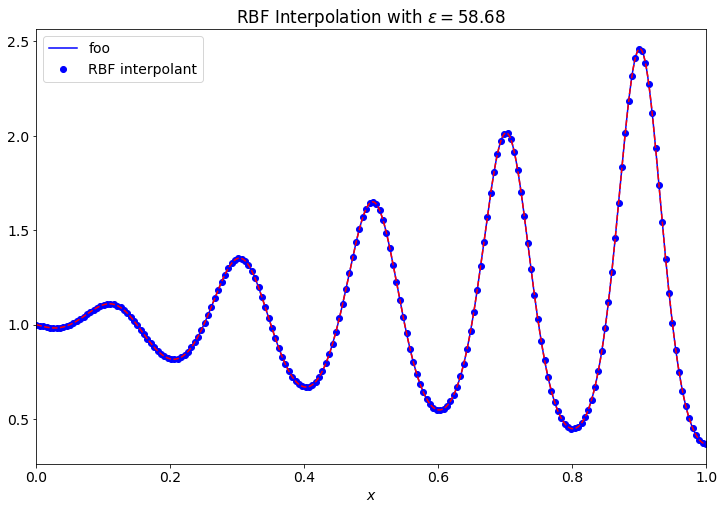

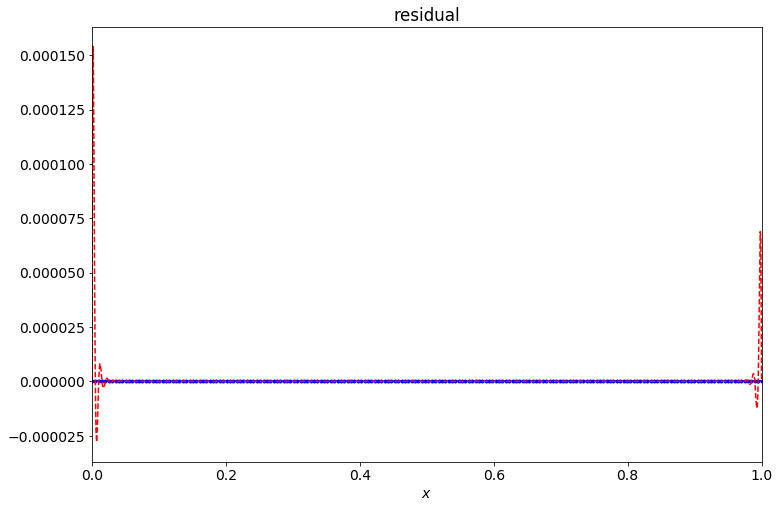

In [17]:
def foo(x):
    return np.exp(-np.cos(10*np.pi*x) * x)

n = 200
xs = gen_points(0,1,n, kind='equal')

zs = np.linspace(0,1, 1000)
fs = foo(zs)

'''fig = plt.figure(figsize=(12,4))
plt.plot(zs, fs, 'b-')
plt.plot(xs, foo(xs), 'bo')
plt.title('The function foo sampled at %d points' % n)
plt.xlim((0,1))
plt.show()'''

rbf = rbf_dict['gaussian']

us, eps, cond = rbf_interp(xs, foo(xs), zs, rbf, optimize_shape=True, target_cond=10**15)
print('epsilon = %.4f'%eps)
print('log cond(A) = %g' % (np.log(cond)/np.log(10)))

err = la.norm(us - fs)/la.norm(fs)
print('error = %g' % err)


#plot
fig = plt.figure(figsize=(12,8))
plt.plot(zs, fs, 'b-')
plt.plot(xs, foo(xs), 'bo')
plt.plot(zs, us, 'r--')
plt.legend(['foo', 'RBF interpolant'])
plt.title('RBF Interpolation with $\\varepsilon=%.2f$'%eps)
plt.xlabel('$x$')
plt.xlim((0,1))
plt.show()

fig = plt.figure(figsize=(12,8))
plt.plot(zs, [0]*len(zs), 'b-')
plt.plot(xs, [0]*len(xs), 'b.')
plt.plot(zs, us-fs, 'r--')
#plt.legend(['0', 'RBF interpolant residual'])
plt.title('residual')
plt.xlabel('$x$')
plt.xlim((0,1))
plt.show()

In [18]:
n = 200
epsilons = np.block([np.linspace(5,10,20,endpoint=False), range(10, 200)])
target_cond = 10**12
rbf = rbf_dict['gaussian']
xs = gen_points(0,1,n, kind='halton')



zs = np.linspace(0,1, n*20)
fs = foo(zs)

errs = []
conds = []

for eps in epsilons:
    us, eps, cond = rbf_interp(xs, foo(xs), zs, rbf, eps=eps, optimize_shape=False, target_cond=target_cond)
    errs += [la.norm(us - fs)/la.norm(fs)]
    conds += [cond]
    

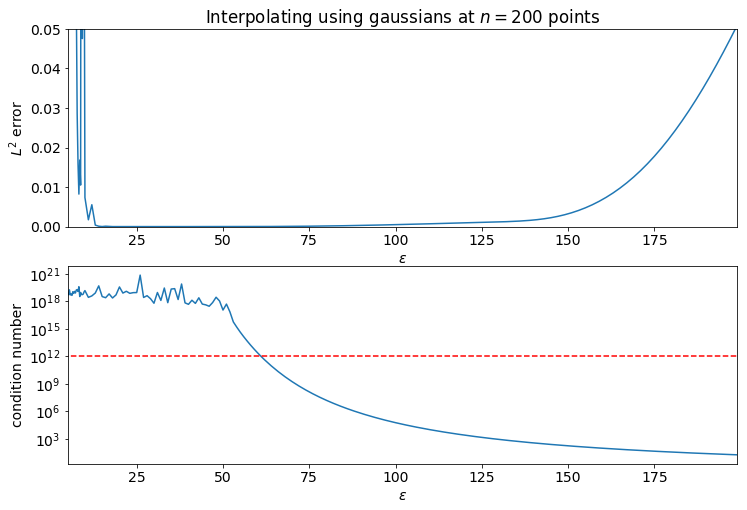

In [33]:
fig, axs = plt.subplots(2, sharex=True, figsize=(12,8))

#fig = plt.figure(figsize=(12,8))
axs[0].plot(epsilons, errs)
axs[0].set_ylim(0,.05)
axs[0].set_xlabel('$\\varepsilon$')
axs[0].set_ylabel('$L^2$ error')
axs[0].set_title('Interpolating using gaussians at $n=%d$ points' % n)

axs[0].tick_params(labelbottom=True)
#plt.show()

#fig = plt.figure(figsize=(12,8))
axs[1].semilogy(epsilons, conds)
axs[1].plot([-1,np.max(epsilons)], [target_cond, target_cond], 'r--')
axs[1].set_xlabel('$\\varepsilon$')
axs[1].set_ylabel('condition number')
#axs[1].set_title('Interpolating using gaussians at $n=%d$ points' % n)

plt.xlim(np.min(epsilons), np.max(epsilons))
plt.show()